# Continuous Grid World

In [1]:
import numpy as np
import random, copy
from math import exp,sqrt,pi
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.optimize import linprog
from continuous_grid_world import ContinousGridWorld, ContinuousGridWorldSolver

Actions:
* 0 - Up
* 1 - Down
* 2 - Left
* 3 - Right

## Environment


Environment: Continuous Grid World

Action Space: 4

Observation Space: ([0, 1], [0, 1])

Discretization: 50

Reward Region: [0.8,1] x [0.8,1]

Reward Region Discretized: 40 x 40


Reward:


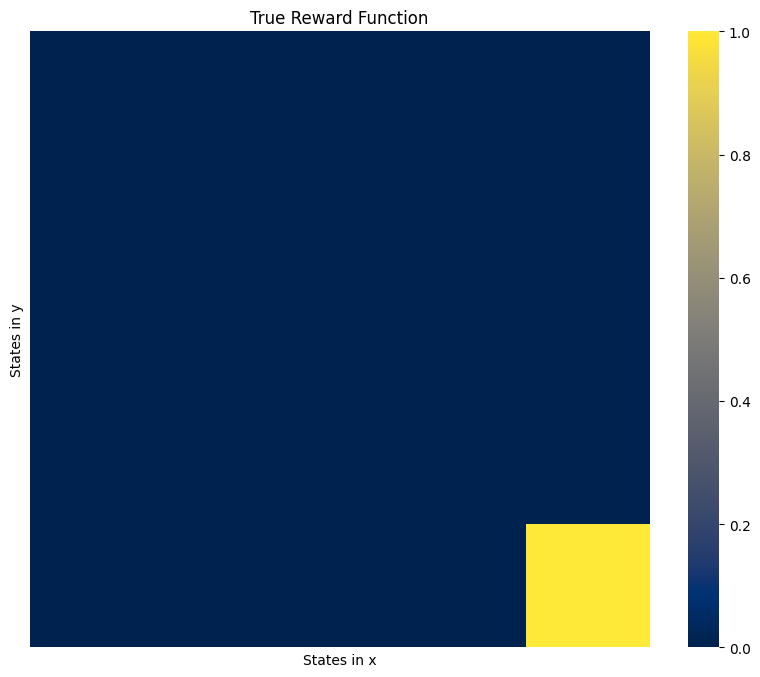

In [2]:
N = 50
env = ContinousGridWorld(N)

print('\nEnvironment: Continuous Grid World')
print('\nAction Space:', env.action_space)
print('\nObservation Space:', env.observation_space)
print('\nDiscretization:', env.N)
print('\nReward Region: [0.8,1] x [0.8,1]')
print(f'\nReward Region Discretized: {env.reward_region} x {env.reward_region}')

print('\n\nReward:')
env.plot_reward(title='True Reward Function', filename='../Results/Continuous Grid World/True Reward Function.png')

In [3]:
num_of_basis=15

alphas = [0] * (num_of_basis * num_of_basis)

# mean values along the x-axis for basis functions
x_basis_mean = [i / (num_of_basis - 1) for i in range(num_of_basis - 1)] + [1.0]

# mean values along the x-axis for basis functions
y_basis_mean = [i / (num_of_basis - 1) for i in range(num_of_basis - 1)] + [1.0]

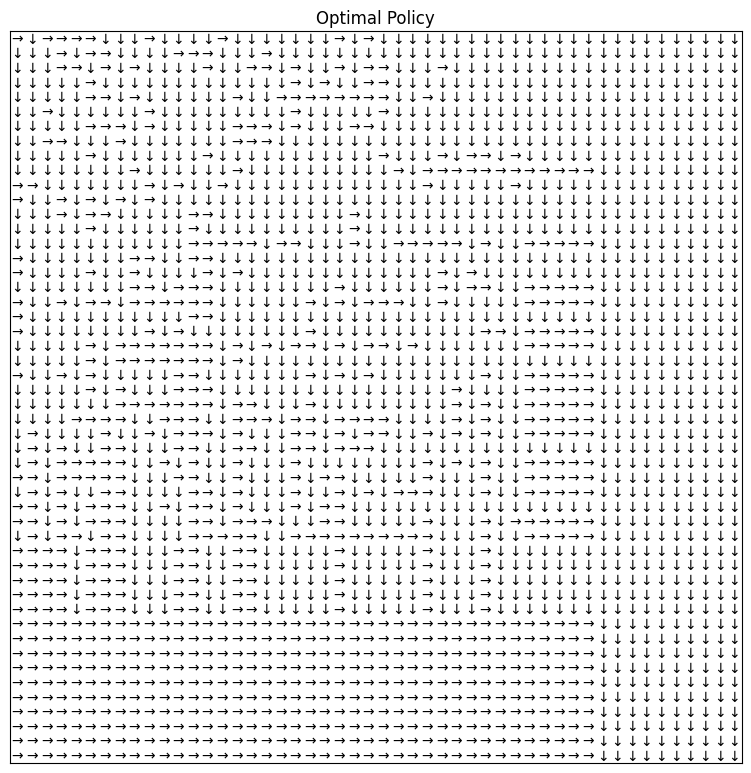

In [4]:
continuous_irl = ContinuousGridWorldSolver(N=50, region=0.8, error=0.1, move_length=0.2, gamma=0.9)

# obtaining the optimal policy using Value Iteration
policy_predicted, V = continuous_irl.get_optimal_policy(N, None)

continuous_irl.plot_policy_matrix(policy_predicted, title='Optimal Policy')

# Inverse Reinforcement Learning

## Monte Carlo Trajectories

In [5]:
# function to generate monte carlo trajectories

def get_monte_carlo_trajectories(env, policy, trajectory_length, m):
    
    trajectories = []

    for _ in range(m):
        i, j = 0, 0
        trajectory = [[i, j]]

        # generate trajectory of 'trajectory_length' steps based on the given policy
        for _ in range(trajectory_length - 1):
            
            # get action from the policy (bounded by 49 to prevent index errors)
            action = policy[min(49, round(i * 50))][min(49, round(j * 50))]

            # move based on the selected action
            i, j, absorbing_state = env.move(i, j, action)

            trajectory.append([i, j])

            # check if an absorbing state is reached
            if absorbing_state:
                break

        trajectories.append(trajectory)

    return trajectories

In [6]:
# execute m=1000 Monte Carlo Trajectories under optimal policy

mc_trajs = get_monte_carlo_trajectories(env, policy_predicted, trajectory_length=30, m=1000)

## Value Function

In [7]:
# function for calculating the probability density function (PDF) of a normal distribution

def get_pdf(x, mean, std_dev):
    z = (x - mean) / std_dev
    pdf = (exp(-(z**2) / 2) / (sqrt(2 * pi) * std_dev))
    return pdf

In [8]:
# function to generate value function

def generate_value_function(trajectories, x_basis_mean, y_basis_mean, scale=0.5, gamma=0.99):
    
    value_function = []

    # for each basis function, the empirical return is estimated
    for i in x_basis_mean:
        for j in y_basis_mean:
            v = 0

            # calculate value function at position (i, j) based on trajectories
            for trajectory in trajectories:
                discount_factor = 1

                # calculate value function using the product of PDFs
                for state in trajectory:
                    y, x = state

                    # calculate PDFs for x and y
                    pdf_x = get_pdf(x, i, scale)
                    pdf_y = get_pdf(y, j, scale)

                    # Update value using PDFs and gamma factor
                    v += discount_factor * pdf_x * pdf_y
                    discount_factor *= gamma

            # Average the value over all trajectories
            v /= len(trajectories)
            value_function.append(v)

    return value_function

In [9]:
# Calculate the value function V^π(s_0)
value_func_predicted = generate_value_function(mc_trajs, x_basis_mean, y_basis_mean)

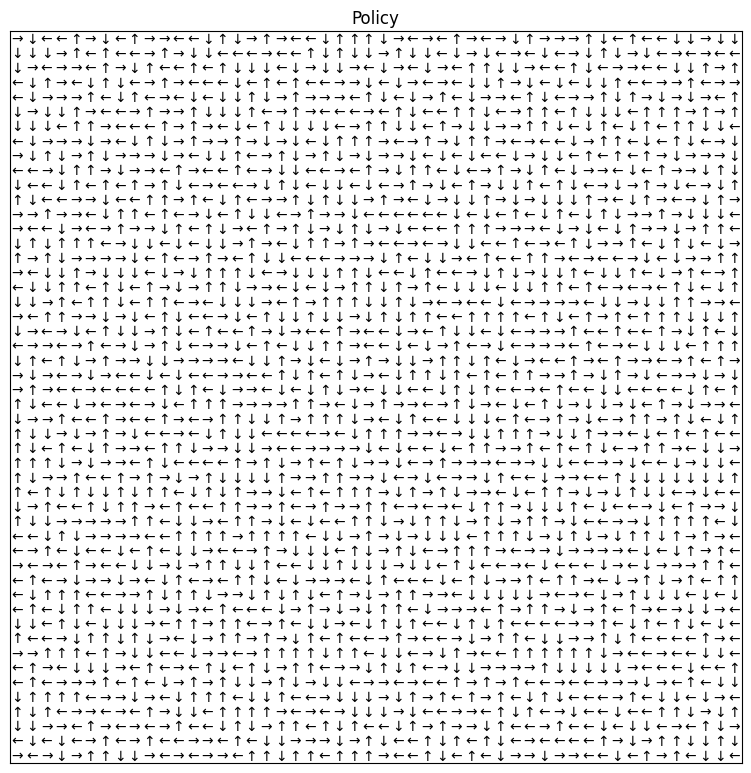

In [15]:
random_policy = [[random.choice(["U", "D", "L", "R"]) for i in range(N)] for j in range(N)]

continuous_irl.plot_policy_matrix(random_policy)

In [11]:
policy_set = [random_policy]

# comparing the predicted policy with a random policy
print('\nSimilarity of predicted policy and random policy: ',
      continuous_irl.compare_policies(policy_predicted, random_policy))


Similarity of predicted policy and random policy:  0.2584


## Linear Programming

In [12]:
# function to solve linear programming problem
def solve_lp(pred, other):
    
    # objective function coefficients
    c = [0] * (num_of_basis * num_of_basis) + [-1] * (len(other))
    
    # constraints matrix
    A = [[0 for i in range(len(c))] for j in range(2 * len(other))]
    b = [0] * (2 * len(other))
    
    # bounds
    bound = [(-1, 1) for i in range(num_of_basis * num_of_basis)] + \
            [(None, None) for j in range(len(other))]

    # constraints for linear programming
    for i in range(len(other)):
        A[2 * i][num_of_basis * num_of_basis + i] = 1
        A[2 * i + 1][num_of_basis * num_of_basis + i] = 1
        for j in range(num_of_basis * num_of_basis):
            A[2 * i][j] = -1 * pred[j] + other[i][j]
            A[2 * i + 1][j] = 4 * (-1 * pred[j] + other[i][j])

    # solve the linear programming problem
    res = linprog(c, A_ub=A, b_ub=b, bounds=bound)

    return res['x']

In [13]:
# function to create a new reward matrix based on value functions and alphas
def make_new_reward(value_functions, alphas):

    new_reward_matrix = [[0 for _ in range(N)] for _ in range(N)]
    
    x_step = 1 / (N * 2)
    i = 0

    while i < N:
        y_step = 1 / (N * 2)
        j = 0

        while j < N:
            # iterate over the basis functions
            for x_index, x_basis in enumerate(x_basis_mean):
                for y_index, y_basis in enumerate(y_basis_mean):
                    tmp_x = get_pdf(x_step, x_basis, 0.5)  # calculate the contribution of each basis function to the reward
                    tmp_y = get_pdf(y_step, y_basis, 0.5)
                    new_reward_matrix[j][i] += alphas[x_index * len(x_basis_mean) + y_index] * tmp_x * tmp_y

            y_step += 1 / N
            j += 1

        x_step += 1 / N
        i += 1

    return new_reward_matrix

## Iterative Algorithm


Iteration 1: 


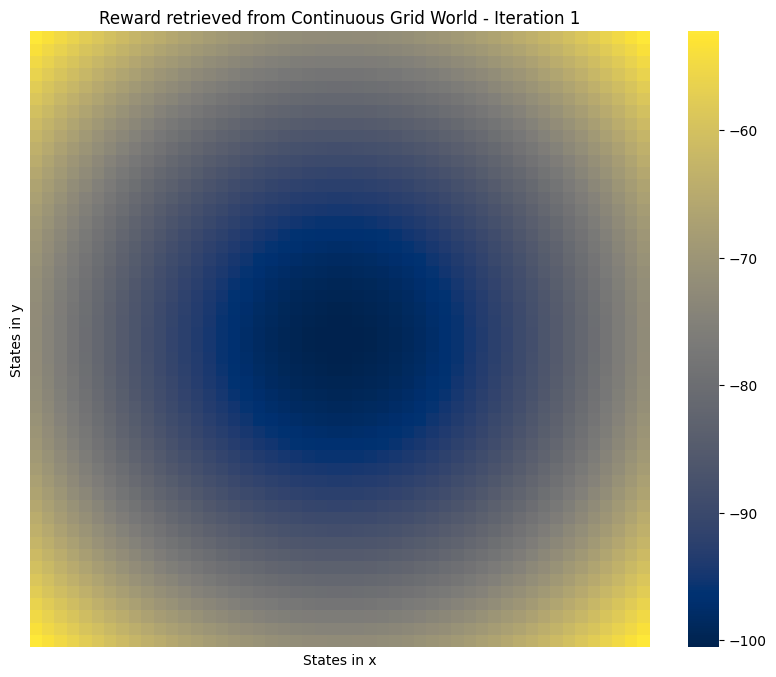

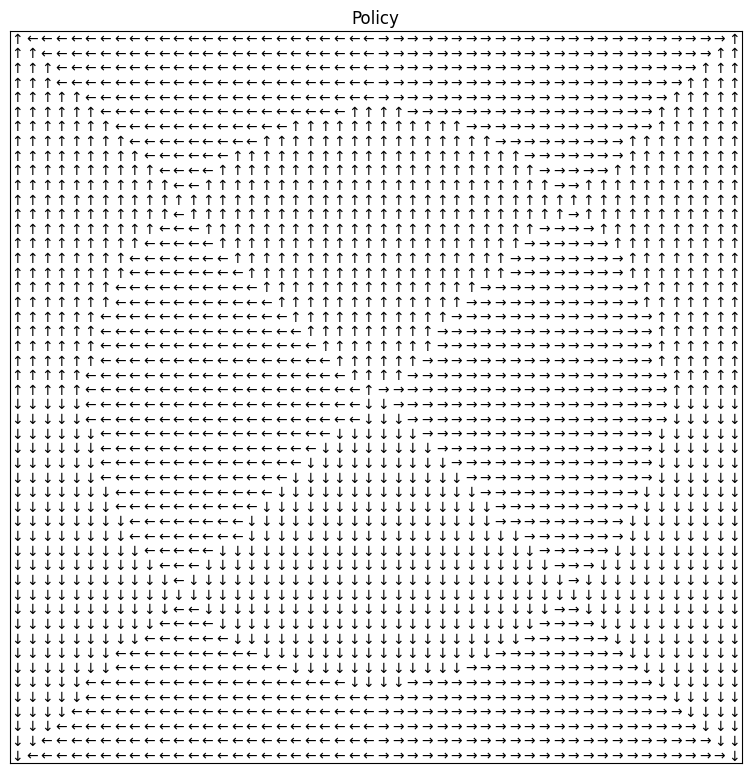


Similarity of predicted policy and obtained policy:  0.2388
Error of optimal policy and policy from obtained reward =  0.7612 

----------------------------------------------------------------------------------------------------

Iteration 2: 


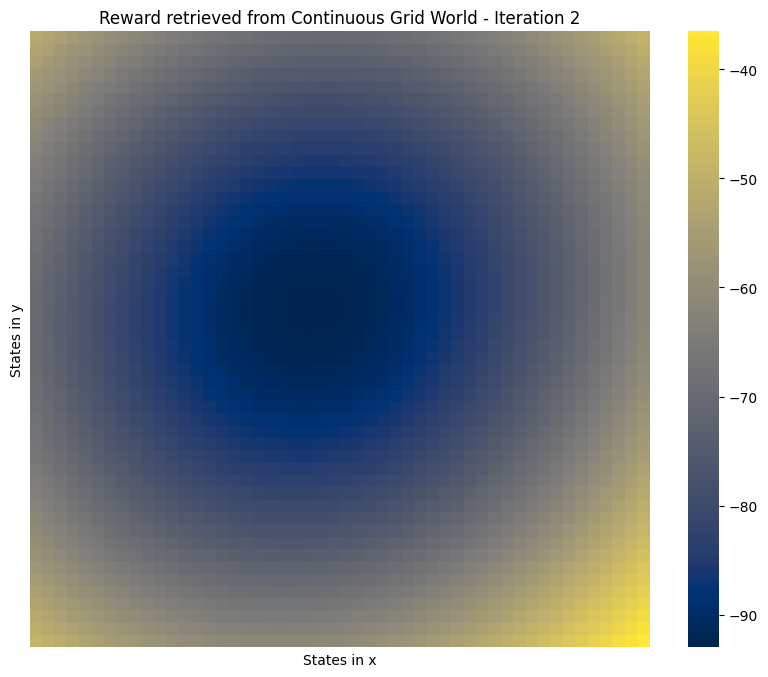

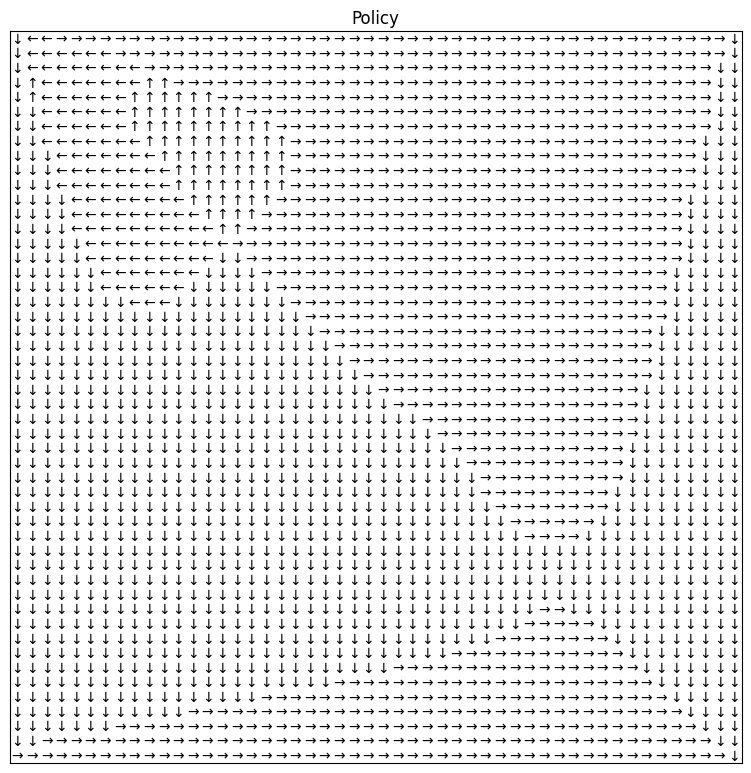


Similarity of predicted policy and obtained policy:  0.452
Error of optimal policy and policy from obtained reward =  0.548 

----------------------------------------------------------------------------------------------------

Iteration 3: 


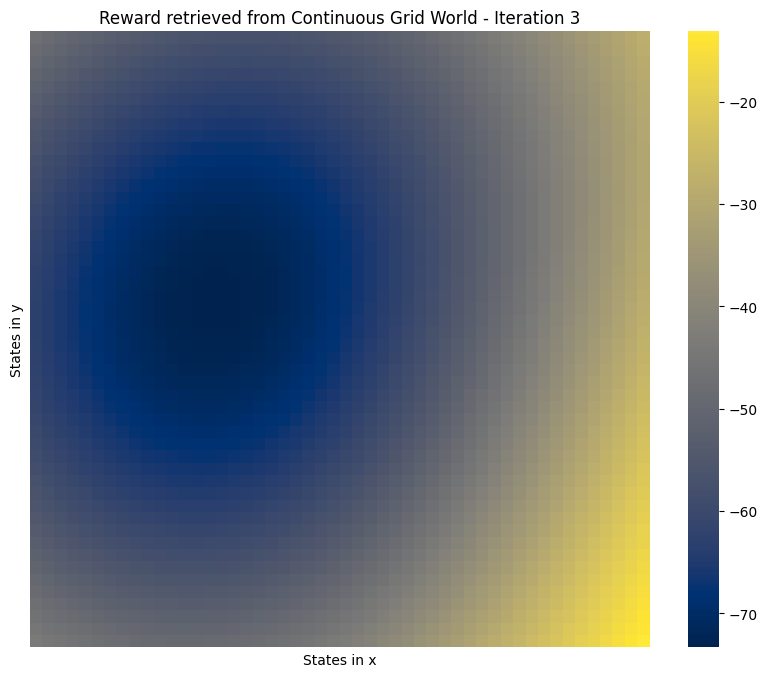

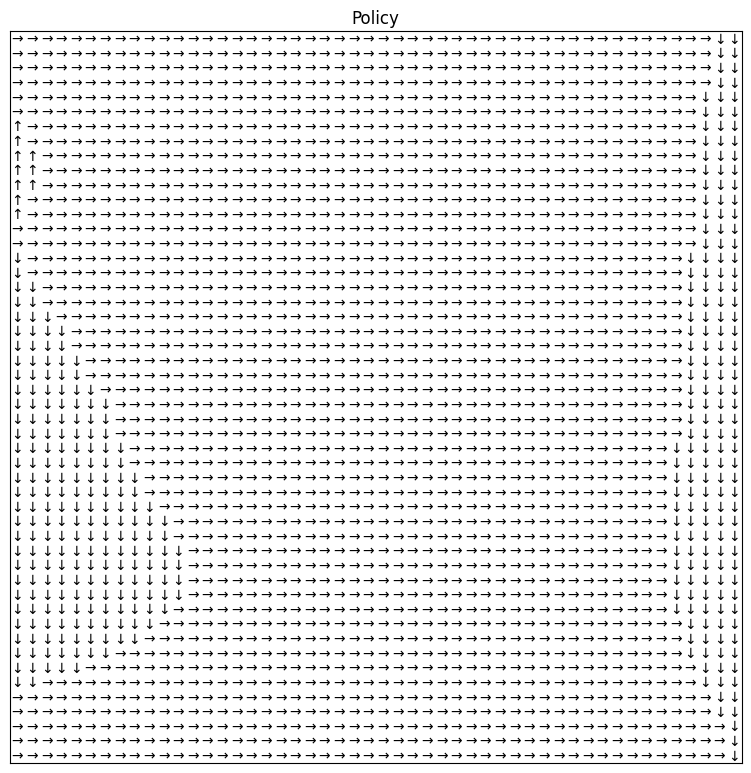


Similarity of predicted policy and obtained policy:  0.418
Error of optimal policy and policy from obtained reward =  0.5820000000000001 

----------------------------------------------------------------------------------------------------

Iteration 4: 


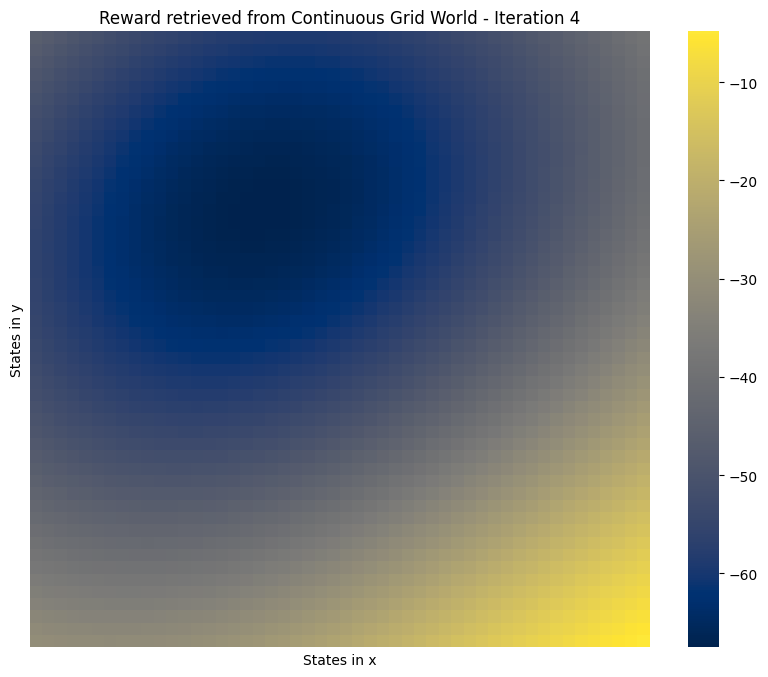

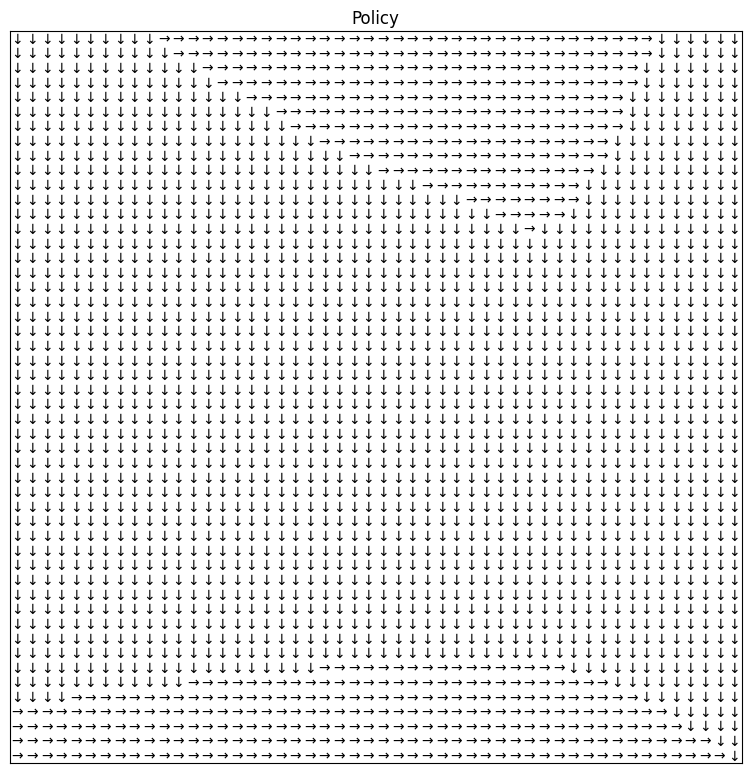


Similarity of predicted policy and obtained policy:  0.6536
Error of optimal policy and policy from obtained reward =  0.34640000000000004 

----------------------------------------------------------------------------------------------------

Iteration 5: 


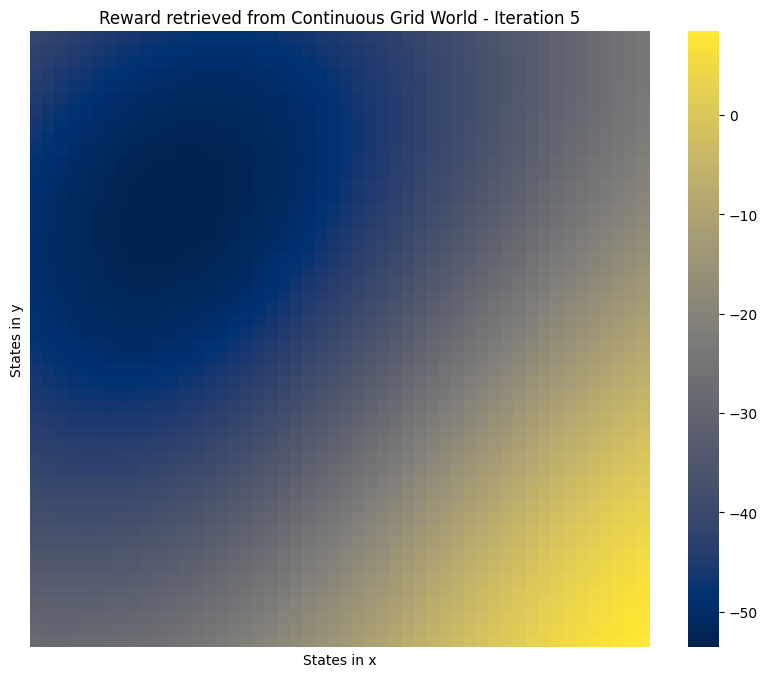

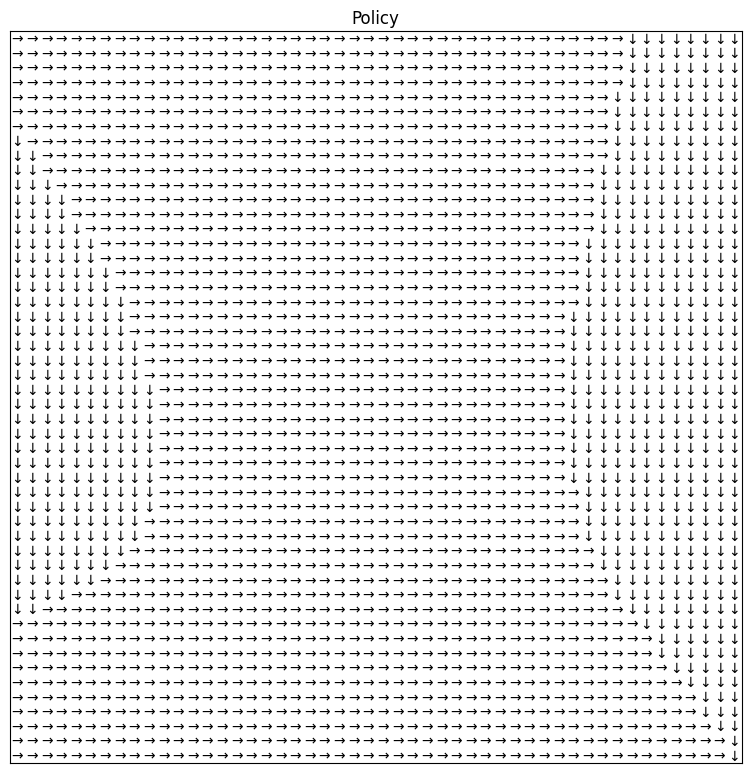


Similarity of predicted policy and obtained policy:  0.5396
Error of optimal policy and policy from obtained reward =  0.46040000000000003 

----------------------------------------------------------------------------------------------------

Iteration 6: 


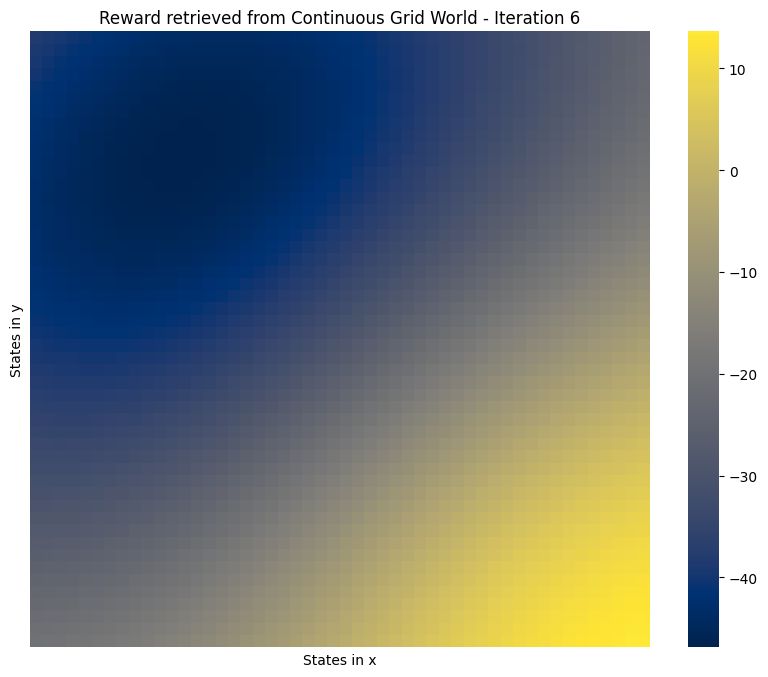

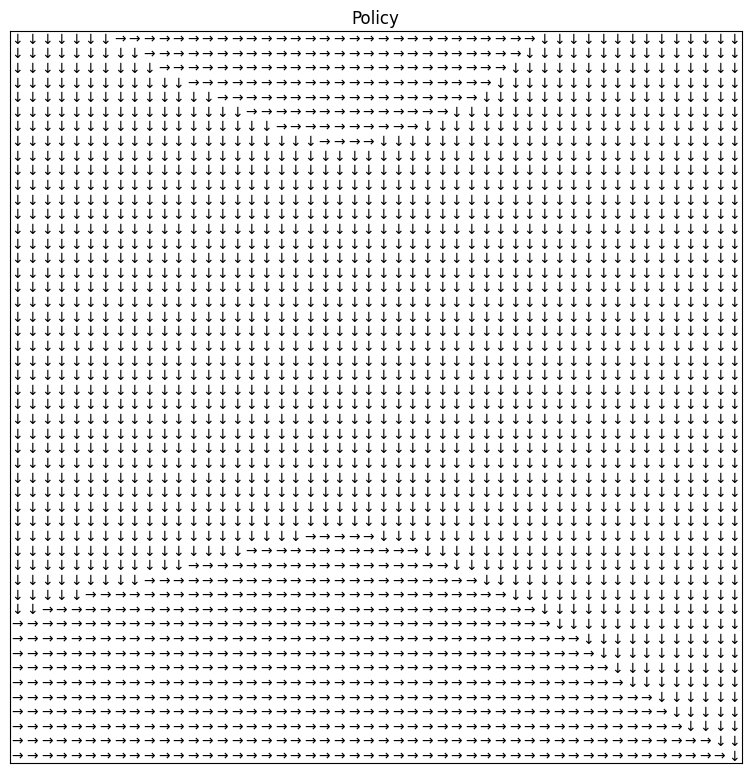


Similarity of predicted policy and obtained policy:  0.736
Error of optimal policy and policy from obtained reward =  0.264 

----------------------------------------------------------------------------------------------------

Iteration 7: 


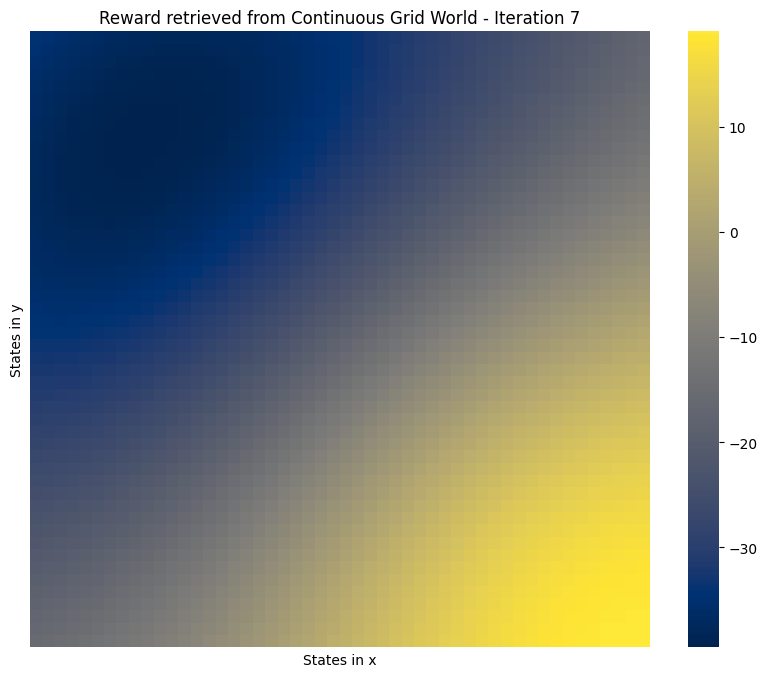

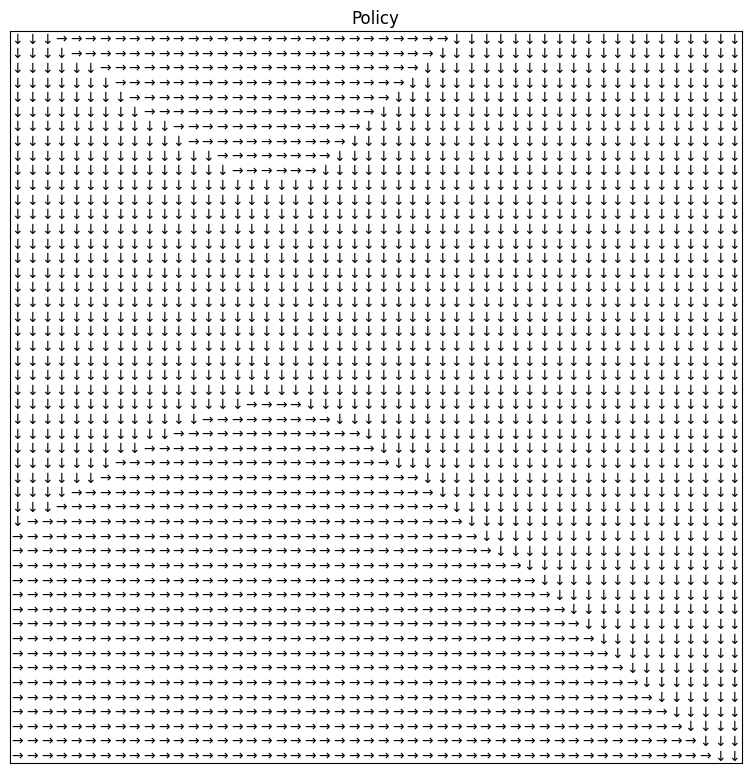


Similarity of predicted policy and obtained policy:  0.7324
Error of optimal policy and policy from obtained reward =  0.26759999999999995 

----------------------------------------------------------------------------------------------------

Iteration 8: 


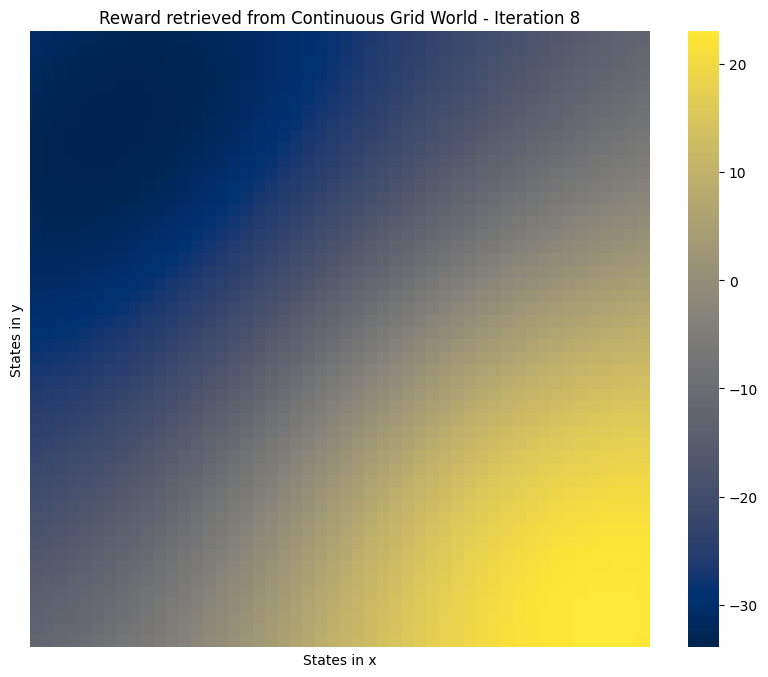

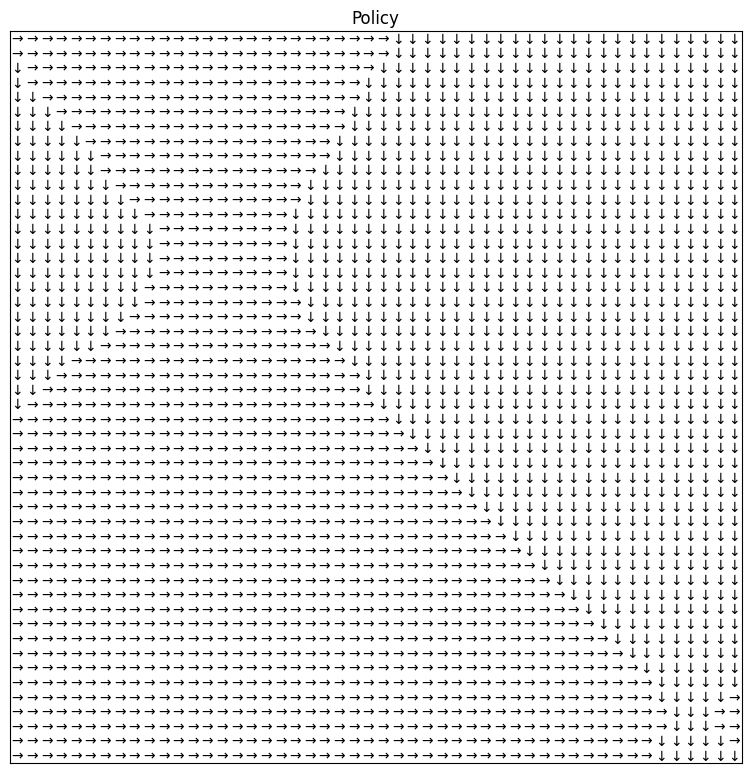


Similarity of predicted policy and obtained policy:  0.6908
Error of optimal policy and policy from obtained reward =  0.30920000000000003 

----------------------------------------------------------------------------------------------------

Iteration 9: 


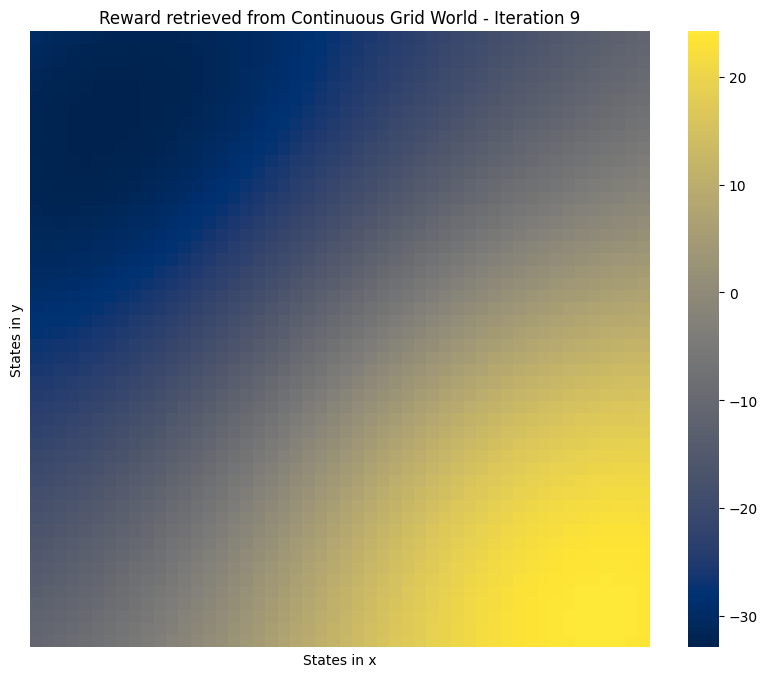

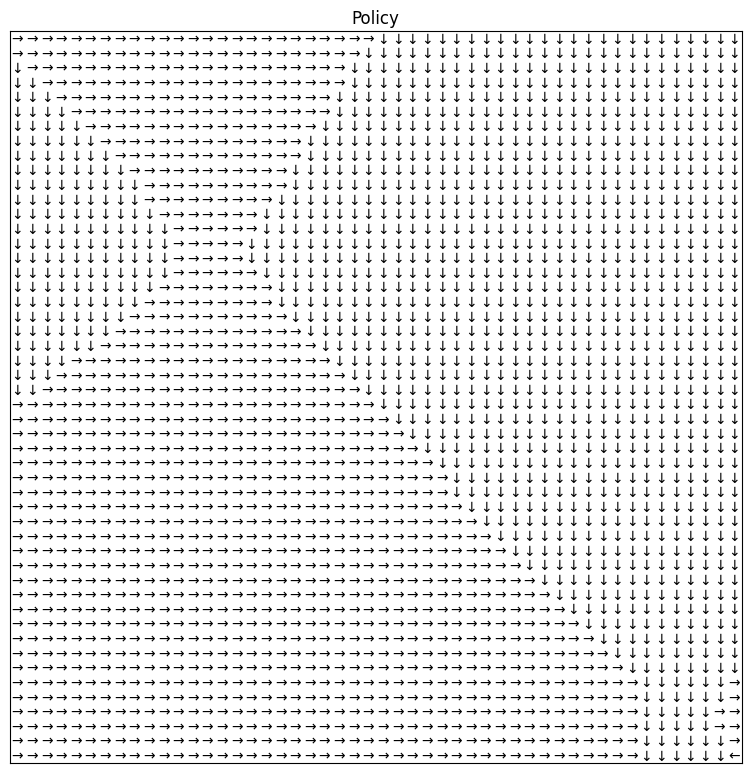


Similarity of predicted policy and obtained policy:  0.7136
Error of optimal policy and policy from obtained reward =  0.2864 

----------------------------------------------------------------------------------------------------

Iteration 10: 


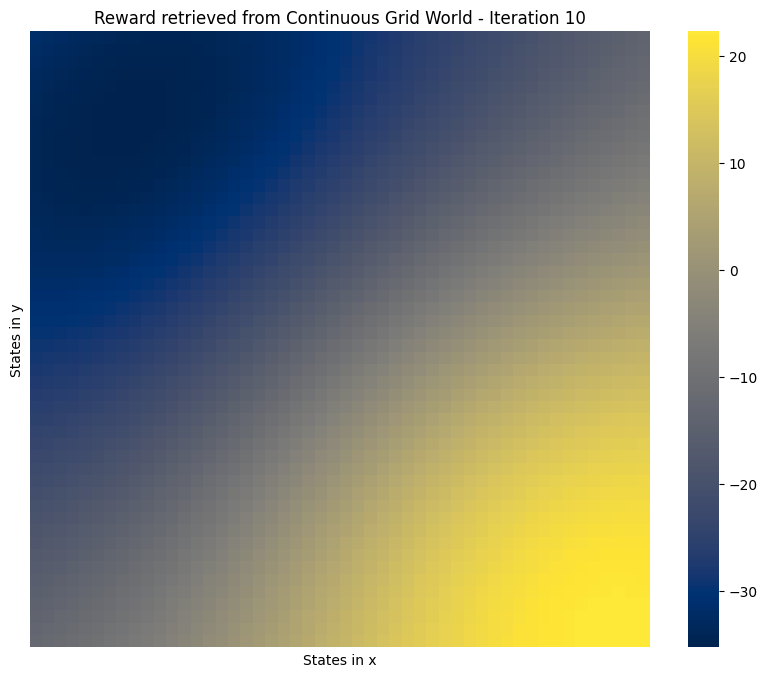

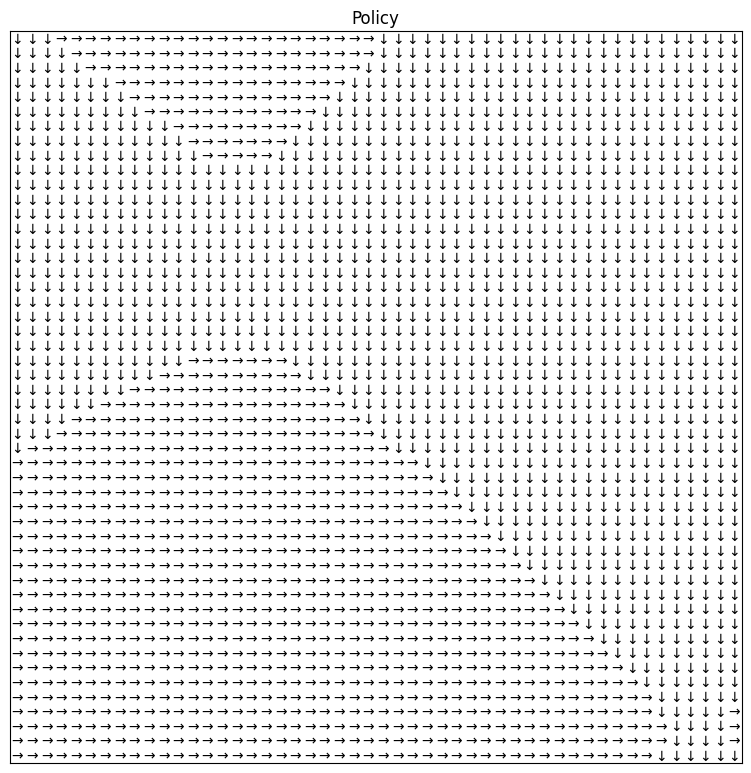


Similarity of predicted policy and obtained policy:  0.7428
Error of optimal policy and policy from obtained reward =  0.2572 

----------------------------------------------------------------------------------------------------


In [14]:
trajectory_set = []
value_function_set = []

for T in range(10):
    print(f'\nIteration {T+1}: ')
    mc_trj = get_monte_carlo_trajectories(env, policy_set[-1], trajectory_length=30, m=1000)
    trajectory_set.append(mc_trj)
    val_func = generate_value_function(trajectory_set[-1], x_basis_mean, y_basis_mean)
    value_function_set.append(val_func)

    alphas = solve_lp(value_func_predicted, value_function_set)

    # make a new reward matrix using the predicted value function and the obtained alphas
    R = make_new_reward(value_func_predicted, alphas)
    continuous_irl.plot_reward_function(R, title=f'Reward retrieved from Continuous Grid World - Iteration {T+1}',
                                       filename=f'../Results/Continuous Grid World/Obtained Reward - Iteration {T+1}')
    print('\n')

    # obtain the optimal policy using the "new reward" matrix
    P, V = continuous_irl.get_optimal_policy(N, R)
    continuous_irl.plot_policy_matrix(P)

    # compare the predicted policy with the obtained policy
    simlr = continuous_irl.compare_policies(policy_predicted, P)
    print('\nSimilarity of predicted policy and obtained policy: ', simlr)
    print('Error of optimal policy and policy from obtained reward = ',(1-simlr),'\n')

    # add the obtained policy to the policy_set
    policy_set.append(P)
    
    print('-' * 100)